# Autoencoder

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## function for variables

In [2]:
def init_weights(shape):
    # golort uniform initialization
    W_init_max = np.sqrt(6. / (shape[0] + shape[1]))
    return tf.Variable(tf.random_uniform(shape, 
                                         minval = W_init_max,
                                        maxval = -W_init_max))

## function for model construction

In [3]:
def model(X, W, b, W_prime, b_prime):
    h = tf.nn.sigmoid(tf.matmul(X, W) + b)  
    reconstruction = tf.nn.sigmoid(tf.matmul(h, W_prime) + b_prime)
    return reconstruction

## Preparing data

In [4]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
X_trn, Y_trn, X_test, Y_test = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## make placeholder for inputs and labels

In [5]:
X = tf.placeholder(tf.float32, [None, 784])

## weight variable 와 Model 만들기
### encoder: W, b
### decoder: W', b'

In [6]:
hidden_dim = 784 // 2 # int로 만들기 위해
W = init_weights([784, hidden_dim])
b = tf.Variable(tf.zeros([hidden_dim]))

W_prime = tf.transpose(W)  # tied weights
b_prime = tf.Variable(tf.zeros([784]))

reconstruction = model(X, W, b, W_prime, b_prime)

## loss function

In [7]:
loss = tf.reduce_mean(tf.reduce_sum(tf.pow(X - reconstruction, 2), reduction_indices=[1]))

## Training operator
#### tf.train.AdagradOptimizer

In [8]:
train_op = tf.train.AdagradOptimizer(learning_rate=0.05).minimize(loss)

## Session initialize 및 training

In [9]:
trn_loss_list = list()
test_loss_list = list()
batch_size = 128
sess = tf.Session()
sess.run(tf.initialize_all_variables())

for i in range(100):
    trn_loss = 0
    for start, end in zip(range(0, len(X_trn), batch_size), range(batch_size, len(X_trn)+1, batch_size)):
        tmp_loss, _ = sess.run([loss, train_op], feed_dict={X: X_trn[start:end]})
        trn_loss += tmp_loss
    trn_loss_list.append(trn_loss / (len(X_trn) // batch_size))
    test_loss = sess.run(loss, feed_dict={X: X_test})
    test_loss_list.append(test_loss)
    print("epoch: {} test loss {:0.4f}".format(i, test_loss))

epoch: 0 test loss 10.6052
epoch: 1 test loss 7.4823
epoch: 2 test loss 6.0487
epoch: 3 test loss 5.1781
epoch: 4 test loss 4.5843
epoch: 5 test loss 4.1527
epoch: 6 test loss 3.8246
epoch: 7 test loss 3.5668
epoch: 8 test loss 3.3586
epoch: 9 test loss 3.1870
epoch: 10 test loss 3.0432
epoch: 11 test loss 2.9210
epoch: 12 test loss 2.8157
epoch: 13 test loss 2.7240
epoch: 14 test loss 2.6434
epoch: 15 test loss 2.5720
epoch: 16 test loss 2.5083
epoch: 17 test loss 2.4509
epoch: 18 test loss 2.3989
epoch: 19 test loss 2.3515
epoch: 20 test loss 2.3084
epoch: 21 test loss 2.2689
epoch: 22 test loss 2.2326
epoch: 23 test loss 2.1991
epoch: 24 test loss 2.1681
epoch: 25 test loss 2.1392
epoch: 26 test loss 2.1123
epoch: 27 test loss 2.0870
epoch: 28 test loss 2.0633
epoch: 29 test loss 2.0409
epoch: 30 test loss 2.0197
epoch: 31 test loss 1.9997
epoch: 32 test loss 1.9808
epoch: 33 test loss 1.9629
epoch: 34 test loss 1.9458
epoch: 35 test loss 1.9296
epoch: 36 test loss 1.9142
epoch: 37 

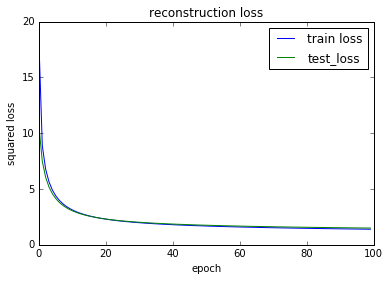

In [10]:
x = np.arange(100)
plt.plot(x, trn_loss_list)
plt.plot(x, test_loss_list)
plt.title("reconstruction loss")
plt.legend(["train loss", "test_loss"])
plt.xlabel("epoch")
plt.ylabel("squared loss")

## Test data reconstruction 보여주기
### 첫번째 row가 original image
### 두번째 row가 reconstruction

/home/jinwon/anaconda3/envs/tensorflow/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


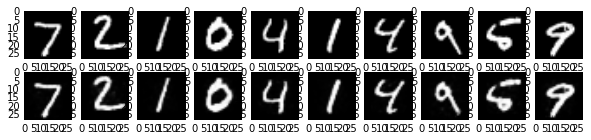

In [11]:
examples_to_show= 10
start_img = 0
recon_image = sess.run(reconstruction, 
                       feed_dict = {X:X_test[start_img:start_img + examples_to_show]})
f, a = plt.subplots(2, examples_to_show, figsize=(10, 2))
for i in range(start_img, examples_to_show):
    a[0][i].imshow(np.reshape(X_test[i], (28, 28)),  cmap=plt.get_cmap('gray'))
    a[1][i].imshow(np.reshape(recon_image[i], (28, 28)),  cmap=plt.get_cmap('gray'))
f.show()

In [12]:
sess.close()

## Denoising model
### dropout 를 이용하여 corruption 만들기

In [13]:
def denoising_model(X, corrupt_prob, W, b, W_prime, b_prime):
    X_corrupt = tf.nn.dropout(X, 1 - corrupt_prob)
    h = tf.nn.sigmoid(tf.matmul(X_corrupt, W) + b)  
    reconstruction = tf.nn.sigmoid(tf.matmul(h, W_prime) + b_prime)
    return X_corrupt, reconstruction

## make placeholder for input and labels

In [14]:
X = tf.placeholder(tf.float32, [None, 784])
corrupt_prob = tf.placeholder(tf.float32) # corruption을 위해서

## weight variable 와 Model 만들기
### encoder: W, b
### decoder: W', b'
### corruption: mask

In [15]:
hidden_dim = 784 // 2 # int로 만들기 위해
W = init_weights([784, hidden_dim])
b = tf.Variable(tf.zeros([hidden_dim]))

W_prime = tf.transpose(W)  # tied weights
b_prime = tf.Variable(tf.zeros([784]))

corrupted_input, denoised_reconstruction = denoising_model(X, corrupt_prob, W, b, W_prime, b_prime)

## loss function

In [16]:
loss = tf.reduce_mean(tf.reduce_sum(tf.pow(X - denoised_reconstruction, 2), reduction_indices=[1]))

## Training operator
#### tf.train.AdagradOptimizer

In [17]:
train_op = tf.train.AdagradOptimizer(learning_rate=0.05).minimize(loss)

## Session initialize 및 training

In [18]:
trn_loss_list = list()
test_loss_list = list()
batch_size = 128
sess = tf.Session()
sess.run(tf.initialize_all_variables())

for i in range(200):
    trn_loss = 0
    for start, end in zip(range(0, len(X_trn), batch_size), range(batch_size, len(X_trn)+1, batch_size)):
        tmp_loss, _ = sess.run([loss, train_op], feed_dict={X: X_trn[start:end], corrupt_prob:0.2})
        trn_loss += tmp_loss
    trn_loss_list.append(trn_loss / (len(X_trn) // batch_size))
    
    test_loss = sess.run(loss, feed_dict={X: X_test, corrupt_prob:0.0})    
    test_loss_list.append(test_loss)
    print("epoch: {} test loss {:0.4f}".format(i, test_loss))

epoch: 0 test loss 11.1764
epoch: 1 test loss 8.1389
epoch: 2 test loss 6.7789
epoch: 3 test loss 5.9745
epoch: 4 test loss 5.4195
epoch: 5 test loss 5.0544
epoch: 6 test loss 4.7423
epoch: 7 test loss 4.4903
epoch: 8 test loss 4.3120
epoch: 9 test loss 4.1514
epoch: 10 test loss 4.0201
epoch: 11 test loss 3.9108
epoch: 12 test loss 3.8385
epoch: 13 test loss 3.7362
epoch: 14 test loss 3.6785
epoch: 15 test loss 3.6035
epoch: 16 test loss 3.5326
epoch: 17 test loss 3.4874
epoch: 18 test loss 3.4609
epoch: 19 test loss 3.3971
epoch: 20 test loss 3.3347
epoch: 21 test loss 3.3167
epoch: 22 test loss 3.2839
epoch: 23 test loss 3.2467
epoch: 24 test loss 3.2253
epoch: 25 test loss 3.1682
epoch: 26 test loss 3.1568
epoch: 27 test loss 3.1139
epoch: 28 test loss 3.0861
epoch: 29 test loss 3.0781
epoch: 30 test loss 3.0578
epoch: 31 test loss 3.0369
epoch: 32 test loss 3.0193
epoch: 33 test loss 2.9767
epoch: 34 test loss 2.9684
epoch: 35 test loss 2.9627
epoch: 36 test loss 2.9390
epoch: 37 

## Loss plot

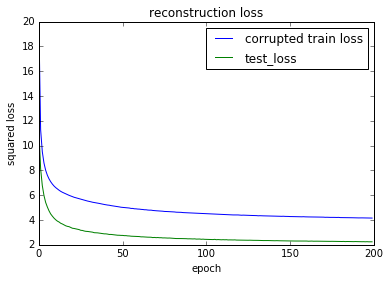

In [19]:
x = np.arange(200)
plt.plot(x, trn_loss_list)
plt.plot(x, test_loss_list)
plt.title("reconstruction loss")
plt.legend(["corrupted train loss", "test_loss"])
plt.xlabel("epoch")
plt.ylabel("squared loss")

## Test data reconstruction 보여주기
### 첫번째 row가 original image
### 두번째 row가 reconstruction

/home/jinwon/anaconda3/envs/tensorflow/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


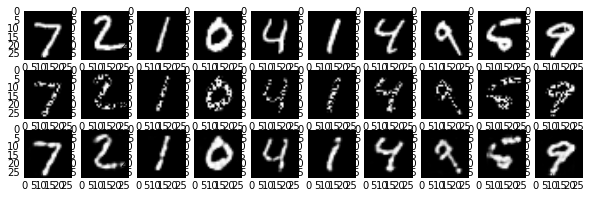

In [20]:
examples_to_show= 10
start_img = 0
corrupted_image, recon_image = sess.run([corrupted_input, denoised_reconstruction], 
                       feed_dict = {X:X_test[start_img:start_img+examples_to_show], corrupt_prob:0.5})
f, a = plt.subplots(3, examples_to_show, figsize=(10, 3))
for i in range(start_img, examples_to_show):
    a[0][i].imshow(np.reshape(X_test[i], (28, 28)), cmap=plt.get_cmap('gray'))
    a[1][i].imshow(np.reshape(corrupted_image[i], (28, 28)), cmap=plt.get_cmap('gray'))
    a[2][i].imshow(np.reshape(recon_image[i], (28, 28)), cmap=plt.get_cmap('gray'))
f.show()

In [21]:
sess.close()